Using a Kaggle dataset to identify the cuisine of a recipe based on the ingredients it uses



## Load dataset from RecipeNet - Kaggle Cuisine Classification problem

In [20]:
import pandas as pd
import numpy as np
import re

from collections import Counter,defaultdict
import datetime
import json
from pprint import pprint
import dill

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from nltk.stem import WordNetLemmatizer

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import  MultinomialNB


In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [5]:
root_dir='/Users/aliceallafort/Google_Drive/Github/'
datasets_dir=root_dir+'RecipeNet/'
save_dir=root_dir+'Miamiam/datasets/'

train_json_file =  datasets_dir+'recipe-ingr/train.json'
test_json_file =  datasets_dir+'recipe-ingr/test.json'

In [6]:
with open(train_json_file, 'rb') as f:
    recipe_ingr_train = json.loads(f.read().decode("utf-8"))
with open(test_json_file, 'rb') as f:
    recipe_ingr_test = json.loads(f.read().decode("utf-8"))

recipe_ingr = recipe_ingr_train + recipe_ingr_test
pprint(recipe_ingr[0])

{'cuisine': 'greek',
 'id': 10259,
 'ingredients': ['romaine lettuce',
                 'black olives',
                 'grape tomatoes',
                 'garlic',
                 'pepper',
                 'purple onion',
                 'seasoning',
                 'garbanzo beans',
                 'feta cheese crumbles']}


In [7]:
train=pd.read_json(train_json_file)
target = train['cuisine']

# Apply label encoding on the target variable (before model development)
lb = LabelEncoder()
train_Y = lb.fit_transform(target)

train['cuisine_encoded'] = train_Y

In [8]:
train.head()

,id,cuisine,ingredients,cuisine_encoded
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",6
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",16
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",4
3,22213,indian,"[water, vegetable oil, wheat, salt]",7
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",7


<AxesSubplot:xlabel='count', ylabel='cuisine'>

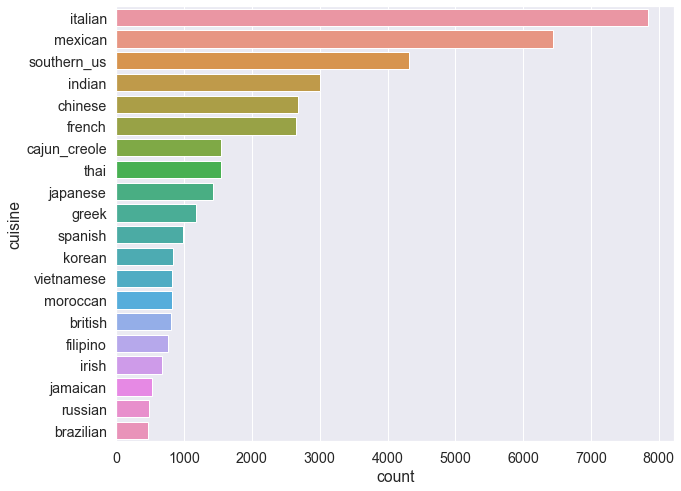

In [11]:
sns.set(font_scale=1.3)
f, ax = plt.subplots(figsize=(10,8))
sns.countplot(y = 'cuisine', 
                   data = train,
                  order = train.cuisine.value_counts(ascending=False).index) 


In [12]:
ingredients_individual = Counter([ingredient for ingredient_list in train.ingredients for ingredient in ingredient_list])
ingredients_individual = pd.DataFrame.from_dict(ingredients_individual,orient='index').reset_index()
ingredients_individual = ingredients_individual.rename(columns={'index':'Ingredient', 0:'Count'})
ingredients_individual

,Ingredient,Count
0,romaine lettuce,270
1,black olives,229
2,grape tomatoes,228
3,garlic,7380
4,pepper,4438
...,...,...
6709,Lipton® Iced Tea Brew Family Size Tea Bags,1
6710,Hidden Valley® Greek Yogurt Original Ranch® Di...,1
6711,lop chong,1
6712,tomato garlic pasta sauce,1


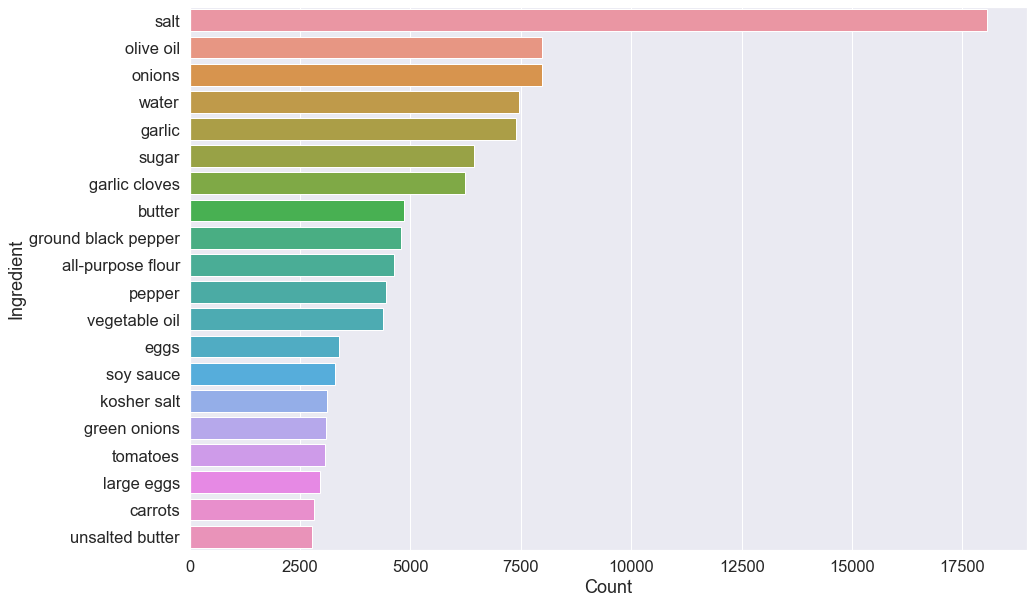

In [13]:
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(x = 'Count', 
            y = 'Ingredient',
            data = ingredients_individual.sort_values('Count', ascending=False).head(20)) ;

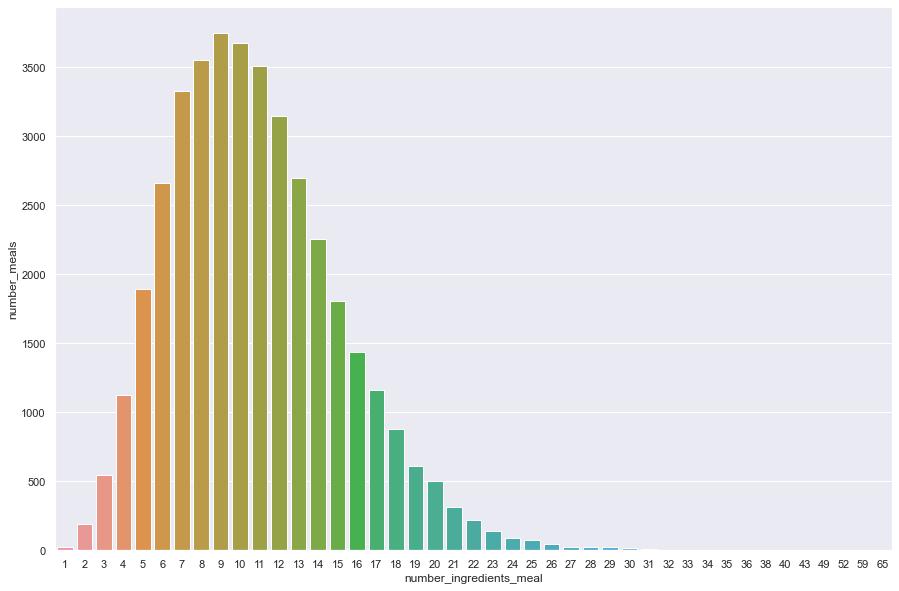

In [21]:
f, ax = plt.subplots(figsize=(15,10))
sns.barplot(x='number_ingredients_meal',
            y='number_meals',
            data= (train.ingredients.map(lambda l: len(l))
                    .value_counts()
                    .sort_index()
                    .reset_index()
                    .rename(columns={'index':'number_ingredients_meal', 'ingredients':'number_meals'}))
            ) 
sns.set(font_scale=1);

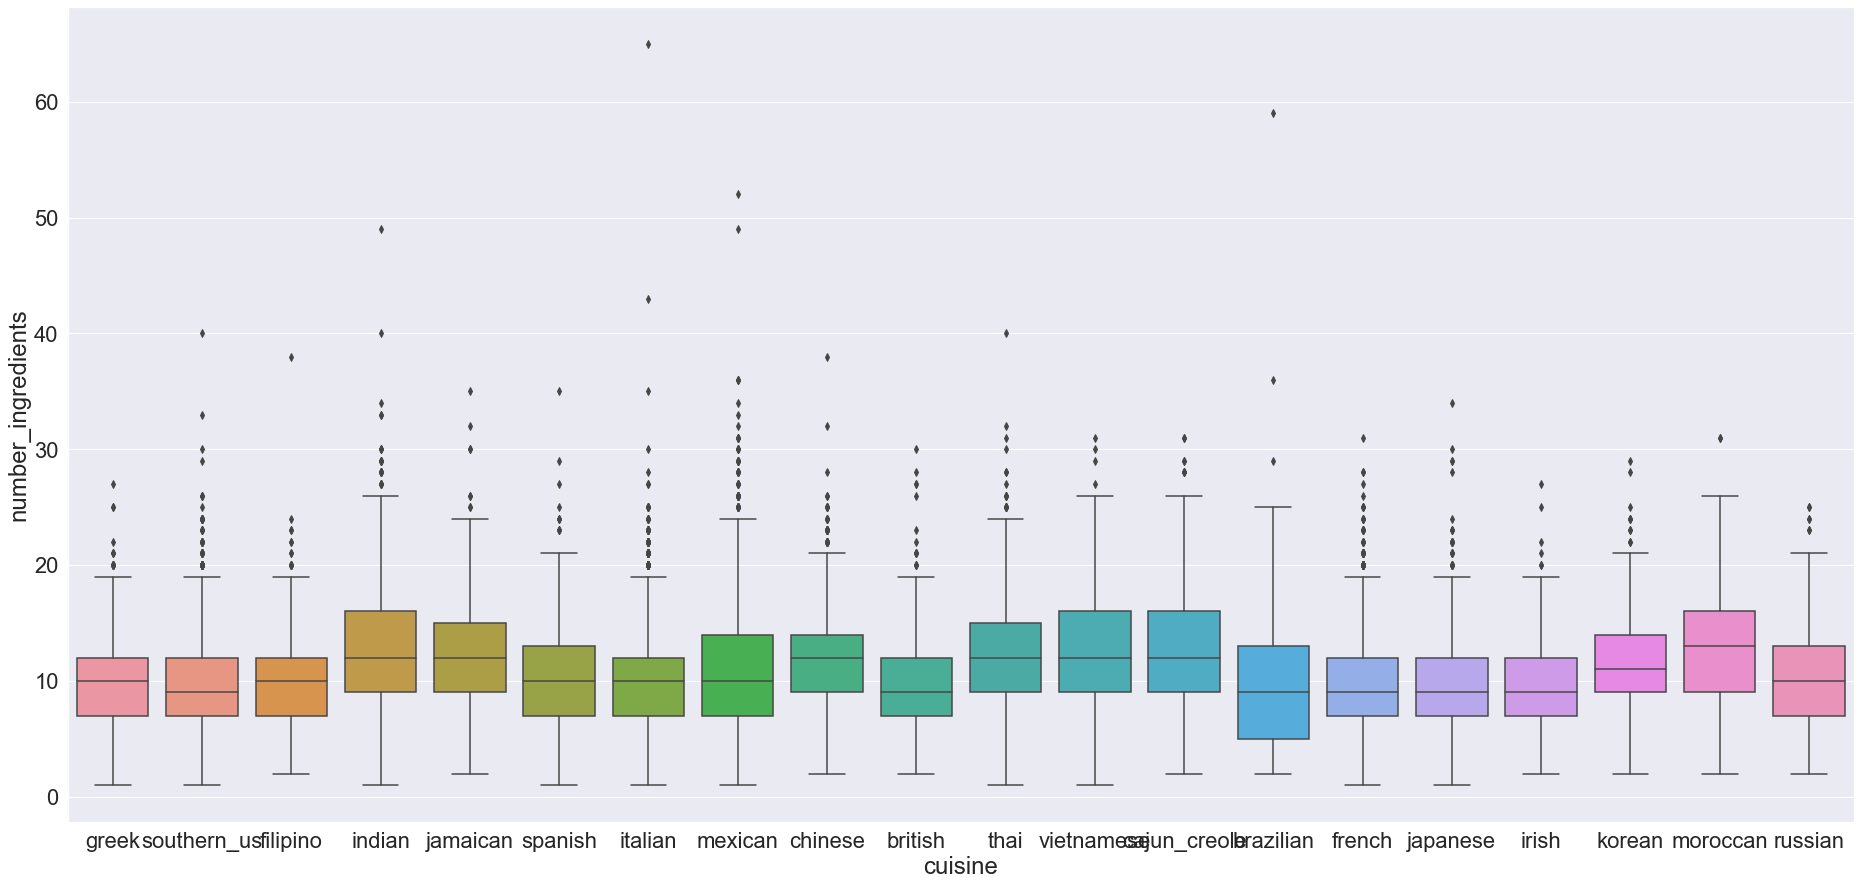

In [18]:
f, ax = plt.subplots(figsize=(32,15))
sns.boxplot(x='cuisine',
            y='number_ingredients',
            data= (pd.concat([train.cuisine,train.ingredients.map(lambda l: len(l))], axis=1)
                    .rename(columns={'ingredients':'number_ingredients'}))
            ) ;

## Logistic  regression

In [4]:
train_data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [12]:
train_data['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [13]:
train_ingredients_count={}
for i in range(len(train_data)):
    for j in train_data['ingredients'][i]:
        if j in train_ingredients_count.keys():
            train_ingredients_count[j]+=1
        else:
            train_ingredients_count[j]=1

In [16]:
dict(sorted(train_ingredients_count.items(), key=lambda item: -item[1]))

{'salt': 18049,
 'onions': 7972,
 'olive oil': 7972,
 'water': 7457,
 'garlic': 7380,
 'sugar': 6434,
 'garlic cloves': 6237,
 'butter': 4848,
 'ground black pepper': 4785,
 'all-purpose flour': 4632,
 'pepper': 4438,
 'vegetable oil': 4385,
 'eggs': 3388,
 'soy sauce': 3296,
 'kosher salt': 3113,
 'green onions': 3078,
 'tomatoes': 3058,
 'large eggs': 2948,
 'carrots': 2814,
 'unsalted butter': 2782,
 'ground cumin': 2747,
 'extra-virgin olive oil': 2747,
 'black pepper': 2627,
 'milk': 2263,
 'chili powder': 2036,
 'oil': 1970,
 'red bell pepper': 1939,
 'purple onion': 1896,
 'scallions': 1891,
 'grated parmesan cheese': 1886,
 'sesame oil': 1773,
 'corn starch': 1757,
 'ginger': 1755,
 'baking powder': 1738,
 'jalapeno chilies': 1730,
 'dried oregano': 1707,
 'chopped cilantro fresh': 1698,
 'fresh lemon juice': 1679,
 'diced tomatoes': 1624,
 'fresh parsley': 1604,
 'minced garlic': 1583,
 'chicken broth': 1554,
 'sour cream': 1539,
 'cayenne pepper': 1523,
 'fresh ginger': 1503,

In [17]:
for i in train_ingredients_count.keys():
    train_data[i]=np.zeros(len(train_data))

##  A combination of Word lemmatization + LinearSVC model

In [4]:
import nltk

In [5]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [6]:
traindf = pd.read_json(train_json_file)
traindf['ingredients_clean_string'] = [' , '.join(z).strip() for z in traindf['ingredients']]  

In [7]:
traindf['ingredients_string'] = [' '.join([lemmatizer.lemmatize(re.sub('[^A-Za-z]', ' ', line)) 
                                           for line in lists]).strip() for lists in traindf['ingredients']]       



In [9]:
lemmatizer.lemmatize('grape tomatoes')

'grape tomatoes'

In [27]:
traindf

,id,cuisine,ingredients,ingredients_clean_string,ingredients_string
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce , black olives , grape tomatoe...",romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour , ground pepper , salt , tomatoes ...",plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs , pepper , salt , mayonaise , cooking oil...",egg pepper salt mayonaise cooking oil green ch...
3,22213,indian,"[water, vegetable oil, wheat, salt]","water , vegetable oil , wheat , salt",water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","black pepper , shallots , cornflour , cayenne ...",black pepper shallot cornflour cayenne pepper ...
...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...","light brown sugar , granulated sugar , butter ...",light brown sugar granulated sugar butter warm...
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...","KRAFT Zesty Italian Dressing , purple onion , ...",KRAFT Zesty Italian Dressing purple onion broc...
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...","eggs , citrus fruit , raisins , sourdough star...",egg citrus fruit raisin sourdough starter flou...
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...","boneless chicken skinless thigh , minced garli...",boneless chicken skinless thigh minced garlic ...


In [17]:
ing_all = Counter([item for sublist in list(traindf.ingredients) for item in sublist])
len(ing_all)

6714

In [20]:
sorted(ing_all.items(),key=lambda item: -item[1])

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113),
 ('green onions', 3078),
 ('tomatoes', 3058),
 ('large eggs', 2948),
 ('carrots', 2814),
 ('unsalted butter', 2782),
 ('ground cumin', 2747),
 ('extra-virgin olive oil', 2747),
 ('black pepper', 2627),
 ('milk', 2263),
 ('chili powder', 2036),
 ('oil', 1970),
 ('red bell pepper', 1939),
 ('purple onion', 1896),
 ('scallions', 1891),
 ('grated parmesan cheese', 1886),
 ('sesame oil', 1773),
 ('corn starch', 1757),
 ('ginger', 1755),
 ('baking powder', 1738),
 ('jalapeno chilies', 1730),
 ('dried oregano', 1707),
 ('chopped cilantro fresh', 1698),
 ('fresh lemon juice', 1679),
 ('diced tomatoes', 1624),
 ('fresh parsley', 1604),
 ('minced garlic', 1583),
 ('chicken

In [32]:
corpustr = traindf['ingredients_string']
vectorizertr = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , token_pattern=r'\w+' , 
                               sublinear_tf=False)
tfidftr=vectorizertr.fit_transform(corpustr).todense()

In [35]:
predictors_tr = tfidftr
targets_tr = traindf['cuisine']

In [39]:
type(predictors_tr)

numpy.matrix

In [ ]:
clf = LogisticRegression()

parameters = {'C':[1, 10]}
classifier = GridSearchCV(clf, parameters)
#classifier = clf
classifier=classifier.fit(predictors_tr,targets_tr)

In [38]:
classifier = LinearSVC(C=0.80, penalty="l2", dual=False)
classifier=classifier.fit(predictors_tr,targets_tr)

In [41]:
predicted = classifier.predict(predictors_tr)

In [43]:
compdf = traindf.copy()
compdf['predicted'] = predicted
compdf[compdf.cuisine!=compdf.predicted]

,id,cuisine,ingredients,ingredients_clean_string,ingredients_string,predicted
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...","plain flour , sugar , butter , eggs , fresh gi...",plain flour sugar butter egg fresh ginger root...,indian
16,34466,british,"[greek yogurt, lemon curd, confectioners sugar...","greek yogurt , lemon curd , confectioners suga...",greek yogurt lemon curd confectioners sugar ra...,greek
19,8152,vietnamese,"[soy sauce, vegetable oil, red bell pepper, ch...","soy sauce , vegetable oil , red bell pepper , ...",soy sauce vegetable oil red bell pepper chicke...,chinese
26,27976,cajun_creole,"[herbs, lemon juice, fresh tomatoes, paprika, ...","herbs , lemon juice , fresh tomatoes , paprika...",herb lemon juice fresh tomatoes paprika mango ...,mexican
37,11300,filipino,"[chicken broth, cooking oil, chinese five-spic...","chicken broth , cooking oil , chinese five-spi...",chicken broth cooking oil chinese five spice p...,chinese
...,...,...,...,...,...,...
39739,5303,indian,"[sugar, all-purpose flour, instant yeast, milk...","sugar , all-purpose flour , instant yeast , mi...",sugar all purpose flour instant yeast milk mel...,french
39745,5511,spanish,"[quinoa, extra-virgin olive oil, fresh thyme l...","quinoa , extra-virgin olive oil , fresh thyme ...",quinoa extra virgin olive oil fresh thyme leav...,cajun_creole
39754,27082,vietnamese,"[jasmine rice, bay leaves, sticky rice, rotiss...","jasmine rice , bay leaves , sticky rice , roti...",jasmine rice bay leaves sticky rice rotisserie...,thai
39759,12153,korean,"[red chili peppers, sea salt, onions, water, c...","red chili peppers , sea salt , onions , water ...",red chili peppers sea salt onion water chilli ...,chinese


## MultinomialNB()

In [104]:
naive = MultinomialNB()
naive.fit(X_train_vectorized,y_train)

pred = naive.predict(X_test_vectorized)
naive.score(X_test_vectorized,y_test)

0.6812067881835324

In [105]:
cuis_epi_nb = naive.predict(X_epi_vectorized)
df_epi['cuisineNB']=cuis_epi_nb
df_epi.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,...,ing_cleaned,ing_cleaned_all,ing_index,ing_assoc,ing_assoc_index,ing_assoc_list,ing_assoc_index_list,recipe_id,cuisine,cuisineNB
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",...,"[carrot, dried brown lentil, dried french gree...",carrot dried brown lentil dried french green l...,"[23, 5199, 2504, 11, 1230, 13, 2505, 9, 84, 52...","[[carrot], [brown lentil], [green lentil], [ol...","[[45], [2337], [2352], [7, 8, 53, 69, 70], [13...","[apple, bibb lettuce, black pepper, breast, br...","[0, 1, 5, 7, 8, 10, 14, 15, 16, 19, 20, 32, 45...",0,french,french
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",...,"[all purpose flour, bay leaves, bay leaves, bu...",all purpose flour bay leaves bay leaves butter...,"[6, 85, 85, 15, 462, 10022, 210, 210, 189, 10,...","[[flour], [bay leaves, bay], [bay leaves, bay]...","[[5], [173, 184], [173, 184], [2], [15, 47, 20...","[baguette, bay, bay leaves, bread, broth, butt...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 15, 17, 21,...",1,french,italian
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",...,"[chicken broth, fennel bulb stalk discarded bu...",chicken broth fennel bulb stalk discarded bulb...,"[81, 10024, 42, 7, 100, 4]","[[chicken, chicken broth, broth], [garnish, fe...","[[15, 47, 201], [66, 256, 773, 2019], [11], [6...","[broth, bulb, butter, chicken, chicken broth, ...","[2, 6, 11, 15, 28, 33, 47, 66, 201, 256, 548, ...",2,french,italian
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",...,"[anchovy paste, country style white bread thic...",anchovy paste country style white bread thick ...,"[476, 10025, 20, 11, 173, 10026, 1913, 7, 67, ...","[[paste, anchovy, anchovy paste], [bread, whit...","[[505, 1082, 1581], [51, 377], [62, 74, 138, 1...","[anchovy, anchovy paste, basil, bread, dry, dr...","[3, 6, 7, 8, 16, 43, 50, 51, 53, 54, 62, 69, 7...",3,italian,italian
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",...,"[extra wide egg noodle cooked, frozen spinach ...",extra wide egg noodle cooked frozen spinach so...,"[10028, 5202, 86, 2177, 346, 38]","[[egg, noodle, egg noodle, wide egg noodle], [...","[[9, 147, 443, 1283], [80, 396], [60, 199], [5...","[cheddar, cheddar cheese, cheese, cream, egg, ...","[9, 12, 13, 35, 37, 42, 60, 80, 147, 199, 257,...",4,italian,italian


In [111]:
probas = naive.predict_proba(X_epi_vectorized)

In [116]:
for c,p in zip(lin.classes_,probas[1]):
    print(c,p)

brazilian 0.0042529016323450105
british 0.02995228308694645
cajun_creole 0.058272448328271775
chinese 0.005444679153498971
filipino 0.007350905300901447
french 0.2768160524979803
greek 0.06241597121724355
indian 0.00703836653487146
irish 0.0272311377228089
italian 0.3815588935785819
jamaican 0.012353383691452563
japanese 0.004340736577413917
korean 0.0018977520769421566
mexican 0.02449267056737907
moroccan 0.012181964182853628
russian 0.006811986836712131
southern_us 0.03444019111163622
spanish 0.03474143616551337
thai 0.002594476863734492
vietnamese 0.005811762872912654


## Recipe cuisine classification - SVC


In [7]:
df = pd.read_json(train_json_file)
test_df = pd.read_json(test_json_file)

In [9]:
def preprocess_df(df):
    
    def process_string(x):
        x = [" ".join([WordNetLemmatizer().lemmatize(q) for q in p.split()]) for p in x] #Lemmatization
        x = list(map(lambda x: re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced','', x), x))
        x = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), x))   # To remove everything except a-z and A-Z
        x = " ".join(x)                                 # To make list element a string element 
        x = x.lower()
        return x
    
    df = df.drop('id',axis=1)
    df['ing_processed'] = df['ingredients'].apply(process_string)
    
    return df

In [10]:
df = preprocess_df(df)
test_df = preprocess_df(test_df)

In [11]:
df.head()

,cuisine,ingredients,ing_processed
0,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olive grape tomato garli...
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour pepper salt tomato black pepper ...
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",egg pepper salt mayonaise cooking oil green ch...
3,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallot cornflour cayenne pepper ...


In [12]:
X = df['ing_processed']  # train
y = df['cuisine'] # target

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
len(y_train),len(y_test)

(31819, 7955)

In [14]:
tfidf = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , 
                        token_pattern=r'\w+' , sublinear_tf=False)

X_train_vectorized  =  tfidf.fit_transform(X_train)
X_test_vectorized  =  tfidf.transform(X_test)

In [52]:
lin = LinearSVC()  #{'C': 1, 'loss': 'hinge', 'penalty': 'l2'}
lin.fit(X_train_vectorized,y_train)

LinearSVC()

In [66]:
pred = lin.predict(X_test_vectorized)
len(pred)

7955

In [83]:
lin.score(X_test_vectorized,y_test)

0.7945945945945946

In [61]:
# 20 cuisines / classes
lin.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [64]:
lin.coef_.shape

(20, 2676)

In [84]:
C = 604
gamma = 0.96

clf = SVC(C=float(C), gamma=float(gamma), kernel='rbf',probability = True)
clf.fit(X_train_vectorized,y_train)

SVC(C=604.0, gamma=0.96, probability=True)

In [69]:
pred = clf.predict(X_test_vectorized)
len(pred),pred

(7955,
 array(['mexican', 'mexican', 'indian', ..., 'korean', 'chinese',
        'italian'], dtype=object))

In [16]:
clf.score(X_test_vectorized,y_test)

0.814833438089252

In [18]:
predict_probas = clf.predict_log_proba(X_test_vectorized)

In [19]:

for c,p in zip(clf.classes_,predict_probas[1]):
    print(c,p)

brazilian -5.83629388580801
british -7.59167168441072
cajun_creole -6.468253625174919
chinese -6.129120628503765
filipino -5.920932206572248
french -6.006284069780506
greek -7.161276053307347
indian -7.677115944882442
irish -7.25614616565368
italian -5.776082422640991
jamaican -7.209112385893859
japanese -6.847347717335941
korean -6.214191527248271
mexican -0.036052549636475986
moroccan -7.5206019777359625
russian -6.9133508099066905
southern_us -5.532924348207973
spanish -5.2994709425859945
thai -6.409430249342986
vietnamese -6.151642020702435


In [22]:
pipe = Pipeline([('tfidf_vect',tfidf),
                 ('SVC',clf)])

In [29]:
with open('estimator.dill', 'wb') as f:
    dill.dump(pipe, f)

In [23]:
predict_X = pipe.predict(X)

In [24]:
df['cuisine_pred'] = predict_X

In [30]:
probas = pipe.predict_proba(X)

In [36]:
df_prob = pd.DataFrame(probas,columns =clf.classes_)
df_prob.head()

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,0.000045,0.000009,0.000156,0.000016,0.000062,0.000392,0.993930,0.000069,0.000015,0.003557,0.000041,0.000006,0.000016,0.000785,0.000275,0.000049,0.000288,0.000229,0.000024,0.000036
1,0.003020,0.005574,0.033656,0.000265,0.002023,0.001971,0.000261,0.001778,0.005160,0.003228,0.015741,0.000089,0.000071,0.004624,0.000088,0.002062,0.916417,0.003836,0.000045,0.000089
2,0.002016,0.000232,0.002019,0.014650,0.944099,0.001895,0.000284,0.001009,0.000676,0.001165,0.001955,0.004691,0.002141,0.004694,0.000256,0.001012,0.005281,0.000890,0.003491,0.007543
3,0.000205,0.000331,0.000273,0.003869,0.001482,0.000976,0.000460,0.958859,0.000425,0.001984,0.001090,0.016485,0.000641,0.006536,0.001218,0.000660,0.000827,0.000813,0.001521,0.001345
4,0.001014,0.001594,0.001544,0.000527,0.001773,0.001656,0.002552,0.958483,0.000334,0.000519,0.000416,0.018219,0.000053,0.005215,0.001075,0.000825,0.002238,0.000624,0.001032,0.000308


In [40]:
pd.concat([df,df_prob],axis=1)

,cuisine,ingredients,ing_processed,cuisine_pred,brazilian,british,cajun_creole,chinese,filipino,french,...,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olive grape tomato garli...,greek,0.000045,0.000009,0.000156,0.000016,0.000062,0.000392,...,0.000041,0.000006,0.000016,0.000785,0.000275,0.000049,0.000288,0.000229,0.000024,0.000036
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour pepper salt tomato black pepper ...,southern_us,0.003020,0.005574,0.033656,0.000265,0.002023,0.001971,...,0.015741,0.000089,0.000071,0.004624,0.000088,0.002062,0.916417,0.003836,0.000045,0.000089
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",egg pepper salt mayonaise cooking oil green ch...,filipino,0.002016,0.000232,0.002019,0.014650,0.944099,0.001895,...,0.001955,0.004691,0.002141,0.004694,0.000256,0.001012,0.005281,0.000890,0.003491,0.007543
3,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt,indian,0.000205,0.000331,0.000273,0.003869,0.001482,0.000976,...,0.001090,0.016485,0.000641,0.006536,0.001218,0.000660,0.000827,0.000813,0.001521,0.001345
4,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallot cornflour cayenne pepper ...,indian,0.001014,0.001594,0.001544,0.000527,0.001773,0.001656,...,0.000416,0.018219,0.000053,0.005215,0.001075,0.000825,0.002238,0.000624,0.001032,0.000308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,irish,"[light brown sugar, granulated sugar, butter, ...",light brown sugar granulated sugar butter warm...,irish,0.000447,0.027602,0.002129,0.003159,0.001671,0.019988,...,0.002205,0.001536,0.000903,0.004986,0.001086,0.004820,0.014734,0.002873,0.000336,0.000723
39770,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...",kraft zesty italian dressing purple onion broc...,italian,0.000633,0.000957,0.002949,0.000987,0.000740,0.007255,...,0.000226,0.001170,0.000193,0.015441,0.001078,0.000929,0.013210,0.001953,0.000391,0.000488
39771,irish,"[eggs, citrus fruit, raisins, sourdough starte...",egg citrus fruit raisin sourdough starter flou...,irish,0.001705,0.029715,0.003295,0.000914,0.001453,0.015528,...,0.012137,0.003516,0.000418,0.003134,0.003178,0.011643,0.023531,0.005077,0.000449,0.000501
39772,chinese,"[boneless chicken skinless thigh, minced garli...",boneless chicken skinless thigh garlic steame...,chinese,0.000043,0.000016,0.000013,0.974430,0.000266,0.000009,...,0.000030,0.018306,0.002103,0.000024,0.000005,0.000023,0.000038,0.000010,0.000940,0.003611


## Apply classification to epicurious dataset

In [63]:
df_epi=pd.read_json(save_dir+'epicurious_ing_cleaned.json')
df_epi['epi_index'] = [i for i in range(len(df_epi))]

In [64]:
df_epi.ing_cleaned_all.iloc[0]

'carrot dried brown lentil dried french green lentil extra virgin olive oil fuji apple ground black pepper head bibb lettuce kosher salt lemon juice low sodium vegetable chicken stock sheet whole wheat lavash cut in half crosswise flour tortilla sprig fresh thyme stalks celery tomato turkey breast'

In [65]:
X_epi = df_epi.ing_cleaned_all
X_epi.shape

(20111,)

In [66]:
with open('estimator.dill', 'rb') as f:
    cuis_class = dill.load(f)

In [67]:
cuis_epi = cuis_class.predict(X_epi)

In [68]:
df_epi['cuisine']=cuis_epi
df_epi.tail()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,...,ing_cleaned,ing_cleaned_all,ing_index,ing_assoc,ing_assoc_index,ing_assoc_list,ing_assoc_index_list,recipe_id,epi_index,cuisine
20125,[Beat whites in a bowl with an electric mixer ...,2.0,2004-08-20 04:00:00,"[Mixer, Cheese, Egg, Fry, Cocktail Party, Parm...",28.0,None,2.0,3.125,Parmesan Puffs,"[2 large egg whites, 3 oz parmigiano-reggiano,...",...,"[egg white, parmigiano reggiano, vegetable oil]",egg white parmigiano reggiano vegetable oil,"[62, 175, 12]","[[egg, egg white], [parmigiano], [vegetable oi...","[[9, 148], [1092], [24, 53]]","[egg, egg white, oil, parmigiano, vegetable oil]","[9, 24, 53, 148, 1092]",20125,20106,italian
20126,[Bring broth to simmer in saucepan.Remove from...,28.0,2008-02-28 22:06:54,"[Side, Kid-Friendly, High Fiber, Dinner, Parme...",671.0,Cooking the artichokes with the rice infuses t...,22.0,4.375,Artichoke and Parmesan Risotto,"[5 1/2 cups (or more) low-salt chicken broth, ...",...,"[arborio rice, baby artichoke trimmed, butter,...",arborio rice baby artichoke trimmed butter dry...,"[410, 9992, 15, 20, 11, 54, 7, 46]","[[rice, arborio rice], [artichoke, baby artich...","[[89, 771], [954, 2757], [2], [62, 74, 138, 16...","[arborio rice, artichoke, baby artichoke, brot...","[0, 2, 6, 7, 8, 12, 15, 31, 41, 47, 53, 62, 69...",20126,20107,italian
20127,"[Using a sharp knife, cut a shallow X in botto...",38.0,2005-10-21 18:21:20,"[Onion, Poultry, turkey, Vegetable, Bake, Kid-...",563.0,None,31.0,4.375,Turkey Cream Puff Pie,"[1 small tomato, 1 small onion, finely chopped...",...,"[all purpose flour, all purpose flour sifted a...",all purpose flour all purpose flour sifted aft...,"[6, 33792, 112, 993, 4441, 1467, 110, 7, 175, ...","[[flour], [flour], [butter, unsalted butter], ...","[[5], [5], [2, 28], [168, 803], [34, 138, 272,...","[broth, butter, cheese, chicken, chicken broth...","[0, 2, 5, 6, 9, 12, 15, 16, 21, 28, 34, 47, 48...",20127,20108,french
20128,[Heat 2 tablespoons oil in heavy medium skille...,24.0,2004-08-20 04:00:00,"[Milk/Cream, Citrus, Dairy, Fish, Garlic, Past...",631.0,"Sharon Hooykaas of Los Alamitos, California, w...",45.0,4.375,Snapper on Angel Hair with Citrus Cream,"[4 tablespoons olive oil, 4 shallots, thinly s...",...,"[additional orange peel, all purpose flour, an...",additional orange peel all purpose flour angel...,"[33794, 6, 2175, 387, 64, 16, 75, 3, 33795, 21...","[[orange, orange peel], [flour], [pasta, angel...","[[50, 539], [5], [99, 1010], [1104], [54, 1007...","[angel hair, basil, clam juice, clove, cream, ...","[3, 5, 7, 8, 13, 16, 23, 46, 50, 53, 54, 62, 7...",20128,20109,italian
20129,[Position rack in bottom third of oven and pre...,10.0,2004-08-20 04:00:00,"[Pork, Bake, Roast, Christmas, Ham, Winter, Bo...",560.0,"Although labeled fully cooked, the ham will st...",73.0,4.375,Baked Ham with Marmalade-Horseradish Glaze,"[1 18-pound fully cooked bone-in smoked ham, r...",...,"[fresh orange juice, fully cooked bone in smok...",fresh orange juice fully cooked bone in smoked...,"[75, 8475, 56, 488, 33796, 5, 113]","[[orange, orange juice, fresh, fresh orange ju...","[[50, 93, 1067, 3154, 3155], [198, 781, 1590],...","[bone in, brown sugar, clove, cream, fresh, fr...","[4, 13, 18, 46, 50, 93, 170, 198, 380, 695, 74...",20129,20110,french


In [69]:
cuis_epi_prob.shape,df_epi.shape

((20111, 20), (20111, 25))

In [70]:
cuis_epi_prob = cuis_class.predict_proba(X_epi)

In [71]:
cuis_epi_prob = pd.DataFrame(cuis_epi_prob,columns =clf.classes_)
cuis_epi_prob.head()

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,0.002092,0.010435,0.061640,0.009508,0.001901,0.286138,0.017344,0.022551,0.023208,0.337674,0.006345,0.006486,0.001230,0.094302,0.016445,0.004962,0.050455,0.042167,0.002871,0.002248
1,0.004052,0.080383,0.034144,0.003373,0.004647,0.438202,0.024427,0.002174,0.058907,0.202885,0.005440,0.001676,0.000460,0.009074,0.002997,0.009391,0.087459,0.027710,0.000889,0.001712
2,0.002959,0.025505,0.005419,0.003529,0.003769,0.364527,0.005048,0.053365,0.285150,0.111749,0.001755,0.004742,0.001027,0.012600,0.005834,0.013792,0.072069,0.024545,0.000698,0.001918
3,0.001641,0.002020,0.004502,0.001342,0.000834,0.192893,0.027705,0.000600,0.000826,0.621036,0.000404,0.001828,0.000415,0.025787,0.001465,0.001267,0.006104,0.107655,0.001077,0.000600
4,0.002115,0.041155,0.006518,0.011133,0.007474,0.059304,0.006135,0.001269,0.021020,0.668404,0.001907,0.022848,0.002874,0.046285,0.000514,0.017240,0.062306,0.013353,0.004650,0.003496


In [74]:
epi_all = pd.merge(df_epi,cuis_epi_prob,left_on='epi_index',right_index=True)
epi_all

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,...,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",...,0.006345,0.006486,0.001230,0.094302,0.016445,0.004962,0.050455,0.042167,0.002871,0.002248
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",...,0.005440,0.001676,0.000460,0.009074,0.002997,0.009391,0.087459,0.027710,0.000889,0.001712
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",...,0.001755,0.004742,0.001027,0.012600,0.005834,0.013792,0.072069,0.024545,0.000698,0.001918
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",...,0.000404,0.001828,0.000415,0.025787,0.001465,0.001267,0.006104,0.107655,0.001077,0.000600
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",...,0.001907,0.022848,0.002874,0.046285,0.000514,0.017240,0.062306,0.013353,0.004650,0.003496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20125,[Beat whites in a bowl with an electric mixer ...,2.0,2004-08-20 04:00:00,"[Mixer, Cheese, Egg, Fry, Cocktail Party, Parm...",28.0,None,2.0,3.125,Parmesan Puffs,"[2 large egg whites, 3 oz parmigiano-reggiano,...",...,0.000793,0.012247,0.002593,0.014439,0.001060,0.011531,0.015230,0.007750,0.002158,0.003007
20126,[Bring broth to simmer in saucepan.Remove from...,28.0,2008-02-28 22:06:54,"[Side, Kid-Friendly, High Fiber, Dinner, Parme...",671.0,Cooking the artichokes with the rice infuses t...,22.0,4.375,Artichoke and Parmesan Risotto,"[5 1/2 cups (or more) low-salt chicken broth, ...",...,0.000022,0.000137,0.000066,0.000353,0.000104,0.000099,0.002002,0.002046,0.000033,0.000047
20127,"[Using a sharp knife, cut a shallow X in botto...",38.0,2005-10-21 18:21:20,"[Onion, Poultry, turkey, Vegetable, Bake, Kid-...",563.0,None,31.0,4.375,Turkey Cream Puff Pie,"[1 small tomato, 1 small onion, finely chopped...",...,0.001329,0.001634,0.000566,0.013922,0.000974,0.045790,0.062378,0.004277,0.000551,0.000600
20128,[Heat 2 tablespoons oil in heavy medium skille...,24.0,2004-08-20 04:00:00,"[Milk/Cream, Citrus, Dairy, Fish, Garlic, Past...",631.0,"Sharon Hooykaas of Los Alamitos, California, w...",45.0,4.375,Snapper on Angel Hair with Citrus Cream,"[4 tablespoons olive oil, 4 shallots, thinly s...",...,0.005327,0.002013,0.000698,0.089574,0.003448,0.002408,0.018669,0.129295,0.003049,0.002731
